<a href="https://colab.research.google.com/github/rodrigolopezlopez/AnalisisCOVIDCDMX/blob/main/%5BCluster_%2B_Risk_Scoring%5D_Anti_Money_Laundering_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cdist

#**2. Data ingestion**

In [ ]:
# Load the dataset
file_path = "/content/drive/MyDrive/Data_sets/Nu/data_accounts.csv"
df = pd.read_csv(file_path)
display(df.head(1))
df.info()

,id,contact_name,date_of_birth,email,state_of_address,card_account_id,card_account_since,deposit_account_id,deposit_account_since,inferred_income,salary_portability,avg_amount_transfer_in_same_cpf,avg_amount_transfer_in_other_cpf,avg_pay_account_balance,avg_amount_transfers_out_same_cpf,avg_amount_transfers_out_other_cpf,avg_amount_purchases,merchant_segment_purchases_concentration,credit_card_limit
0,j4-y3-7l-85,Alvis Ferreras,07/18/1992,aferreras0@hp.com,PR,e706d5cc-f2be-4cd3-86d4-8d5f4a12b694,05/26/2019,b48064d4-c9a5-4ed8-8e9e-832fc597b7a2,02/18/2018,"1,645.14",True,551.31,81.32,990.66,91.89,136.43,87.67,restaurants,64.01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   id                                        4000 non-null   object 
 1   contact_name                              4000 non-null   object 
 2   date_of_birth                             4000 non-null   object 
 3   email                                     4000 non-null   object 
 4   state_of_address                          3982 non-null   object 
 5   card_account_id                           4000 non-null   object 
 6   card_account_since                        4000 non-null   object 
 7   deposit_account_id                        4000 non-null   object 
 8   deposit_account_since                     4000 non-null   object 
 9   inferred_income                           4000 non-null   object 
 10  salary_portability                  

#**3. Data Wrangling**

In [ ]:
# Convert date columns to datetime format
date_columns = ['date_of_birth', 'card_account_since', 'deposit_account_since']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y', errors='coerce')


df['inferred_income'] = df['inferred_income'].astype(str).str.replace(',', '')


df['inferred_income'] = pd.to_numeric(df['inferred_income'], errors='coerce')

# Handle missing values in state_of_address (impute with most frequent state)
df['state_of_address'].fillna(df['state_of_address'].mode()[0], inplace=True)

display(df.head(1))
df.info()

<ipython-input-106-f0b1055a2ac9>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['state_of_address'].fillna(df['state_of_address'].mode()[0], inplace=True)


,id,contact_name,date_of_birth,email,state_of_address,card_account_id,card_account_since,deposit_account_id,deposit_account_since,inferred_income,salary_portability,avg_amount_transfer_in_same_cpf,avg_amount_transfer_in_other_cpf,avg_pay_account_balance,avg_amount_transfers_out_same_cpf,avg_amount_transfers_out_other_cpf,avg_amount_purchases,merchant_segment_purchases_concentration,credit_card_limit
0,j4-y3-7l-85,Alvis Ferreras,1992-07-18,aferreras0@hp.com,PR,e706d5cc-f2be-4cd3-86d4-8d5f4a12b694,2019-05-26,b48064d4-c9a5-4ed8-8e9e-832fc597b7a2,2018-02-18,1645.14,True,551.31,81.32,990.66,91.89,136.43,87.67,restaurants,64.01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   id                                        4000 non-null   object        
 1   contact_name                              4000 non-null   object        
 2   date_of_birth                             4000 non-null   datetime64[ns]
 3   email                                     4000 non-null   object        
 4   state_of_address                          4000 non-null   object        
 5   card_account_id                           4000 non-null   object        
 6   card_account_since                        4000 non-null   datetime64[ns]
 7   deposit_account_id                        4000 non-null   object        
 8   deposit_account_since                     4000 non-null   datetime64[ns]
 9   inferred_income               

#**4. Feature Engineering**

In [ ]:
today = pd.to_datetime("today")
df['account_age_card'] = (today - df['card_account_since']).dt.days
df['account_age_deposit'] = (today - df['deposit_account_since']).dt.days
df['customer_age'] = (today - df['date_of_birth']).dt.days // 365

# Total inflows & outflows
df['total_inflows'] = df['avg_amount_transfer_in_same_cpf'] + df['avg_amount_transfer_in_other_cpf']
df['total_outflows'] = df['avg_amount_transfers_out_same_cpf'] + df['avg_amount_transfers_out_other_cpf']

df['pass_through_ratio'] = df['total_outflows'] / df['total_inflows']
df['pass_through_ratio'].replace([float('inf'), -float('inf')], 0, inplace=True)  # Handle division by zero


df['income_discrepancy_ratio'] = df['total_inflows'] / df['inferred_income']
df['income_discrepancy_ratio'].replace([float('inf'), -float('inf')], 0, inplace=True)


df.drop(columns=['id', 'contact_name', 'email', 'card_account_id', 'deposit_account_id'], inplace=True)

display(df.head(1))
df.info()

<ipython-input-107-3d6b72b60472>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pass_through_ratio'].replace([float('inf'), -float('inf')], 0, inplace=True)  # Handle division by zero
<ipython-input-107-3d6b72b60472>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

,date_of_birth,state_of_address,card_account_since,deposit_account_since,inferred_income,salary_portability,avg_amount_transfer_in_same_cpf,avg_amount_transfer_in_other_cpf,avg_pay_account_balance,avg_amount_transfers_out_same_cpf,...,merchant_segment_purchases_concentration,credit_card_limit,account_age_card,account_age_deposit,customer_age,total_inflows,total_outflows,pass_through_ratio,transaction_velocity,income_discrepancy_ratio
0,1992-07-18,PR,2019-05-26,2018-02-18,1645.14,True,551.31,81.32,990.66,91.89,...,restaurants,64.01,2081,2543,32,632.63,228.32,0.360906,0.338557,0.384545


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   date_of_birth                             4000 non-null   datetime64[ns]
 1   state_of_address                          4000 non-null   object        
 2   card_account_since                        4000 non-null   datetime64[ns]
 3   deposit_account_since                     4000 non-null   datetime64[ns]
 4   inferred_income                           4000 non-null   float64       
 5   salary_portability                        4000 non-null   bool          
 6   avg_amount_transfer_in_same_cpf           4000 non-null   float64       
 7   avg_amount_transfer_in_other_cpf          4000 non-null   float64       
 8   avg_pay_account_balance                   4000 non-null   float64       
 9   avg_amount_transfers_out_same_

#**5. Exploratory Data Analysis**

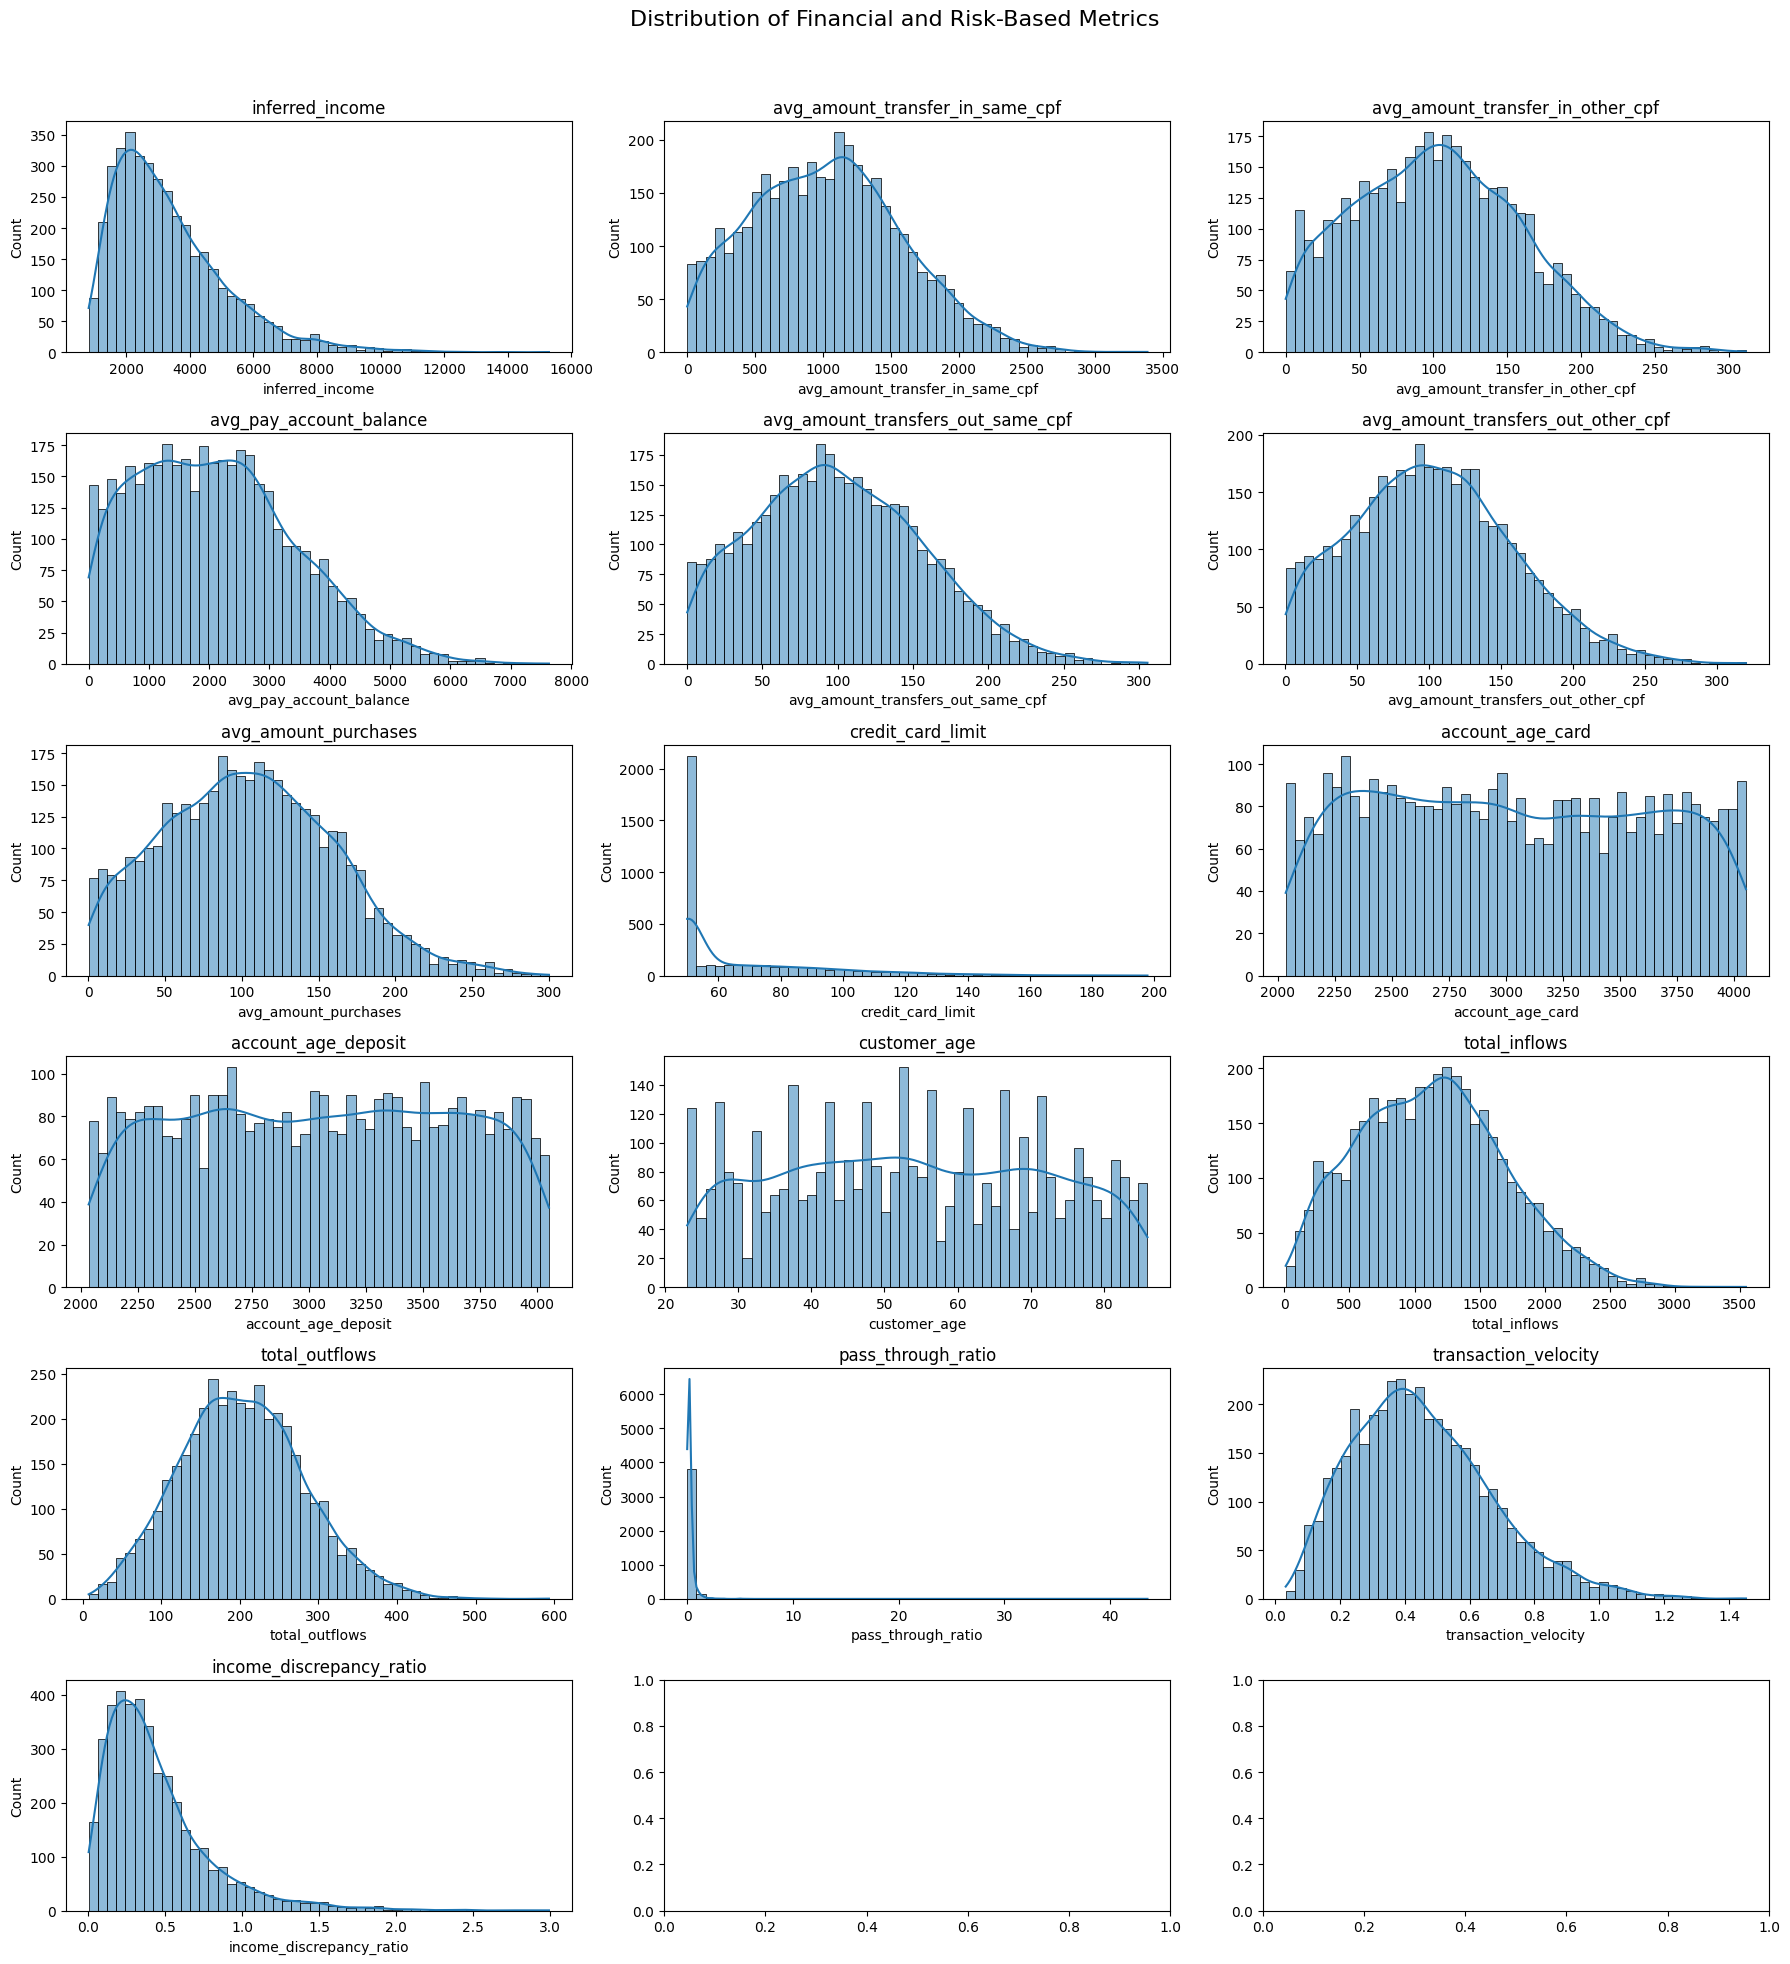

In [ ]:
# Define all financial metrics (original + new)
all_metrics = [
    'inferred_income', 'avg_amount_transfer_in_same_cpf', 'avg_amount_transfer_in_other_cpf',
    'avg_pay_account_balance', 'avg_amount_transfers_out_same_cpf', 'avg_amount_transfers_out_other_cpf',
    'avg_amount_purchases', 'credit_card_limit', 'account_age_card', 'account_age_deposit', 'customer_age',
    'total_inflows', 'total_outflows', 'pass_through_ratio', 'transaction_velocity',
    'income_discrepancy_ratio'
]

# Plot distributions of all financial metrics
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 20))
fig.suptitle("Distribution of Financial and Risk-Based Metrics", fontsize=16)

for ax, col in zip(axes.flatten(), all_metrics):
    sns.histplot(df[col], bins=50, kde=True, ax=ax)
    ax.set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


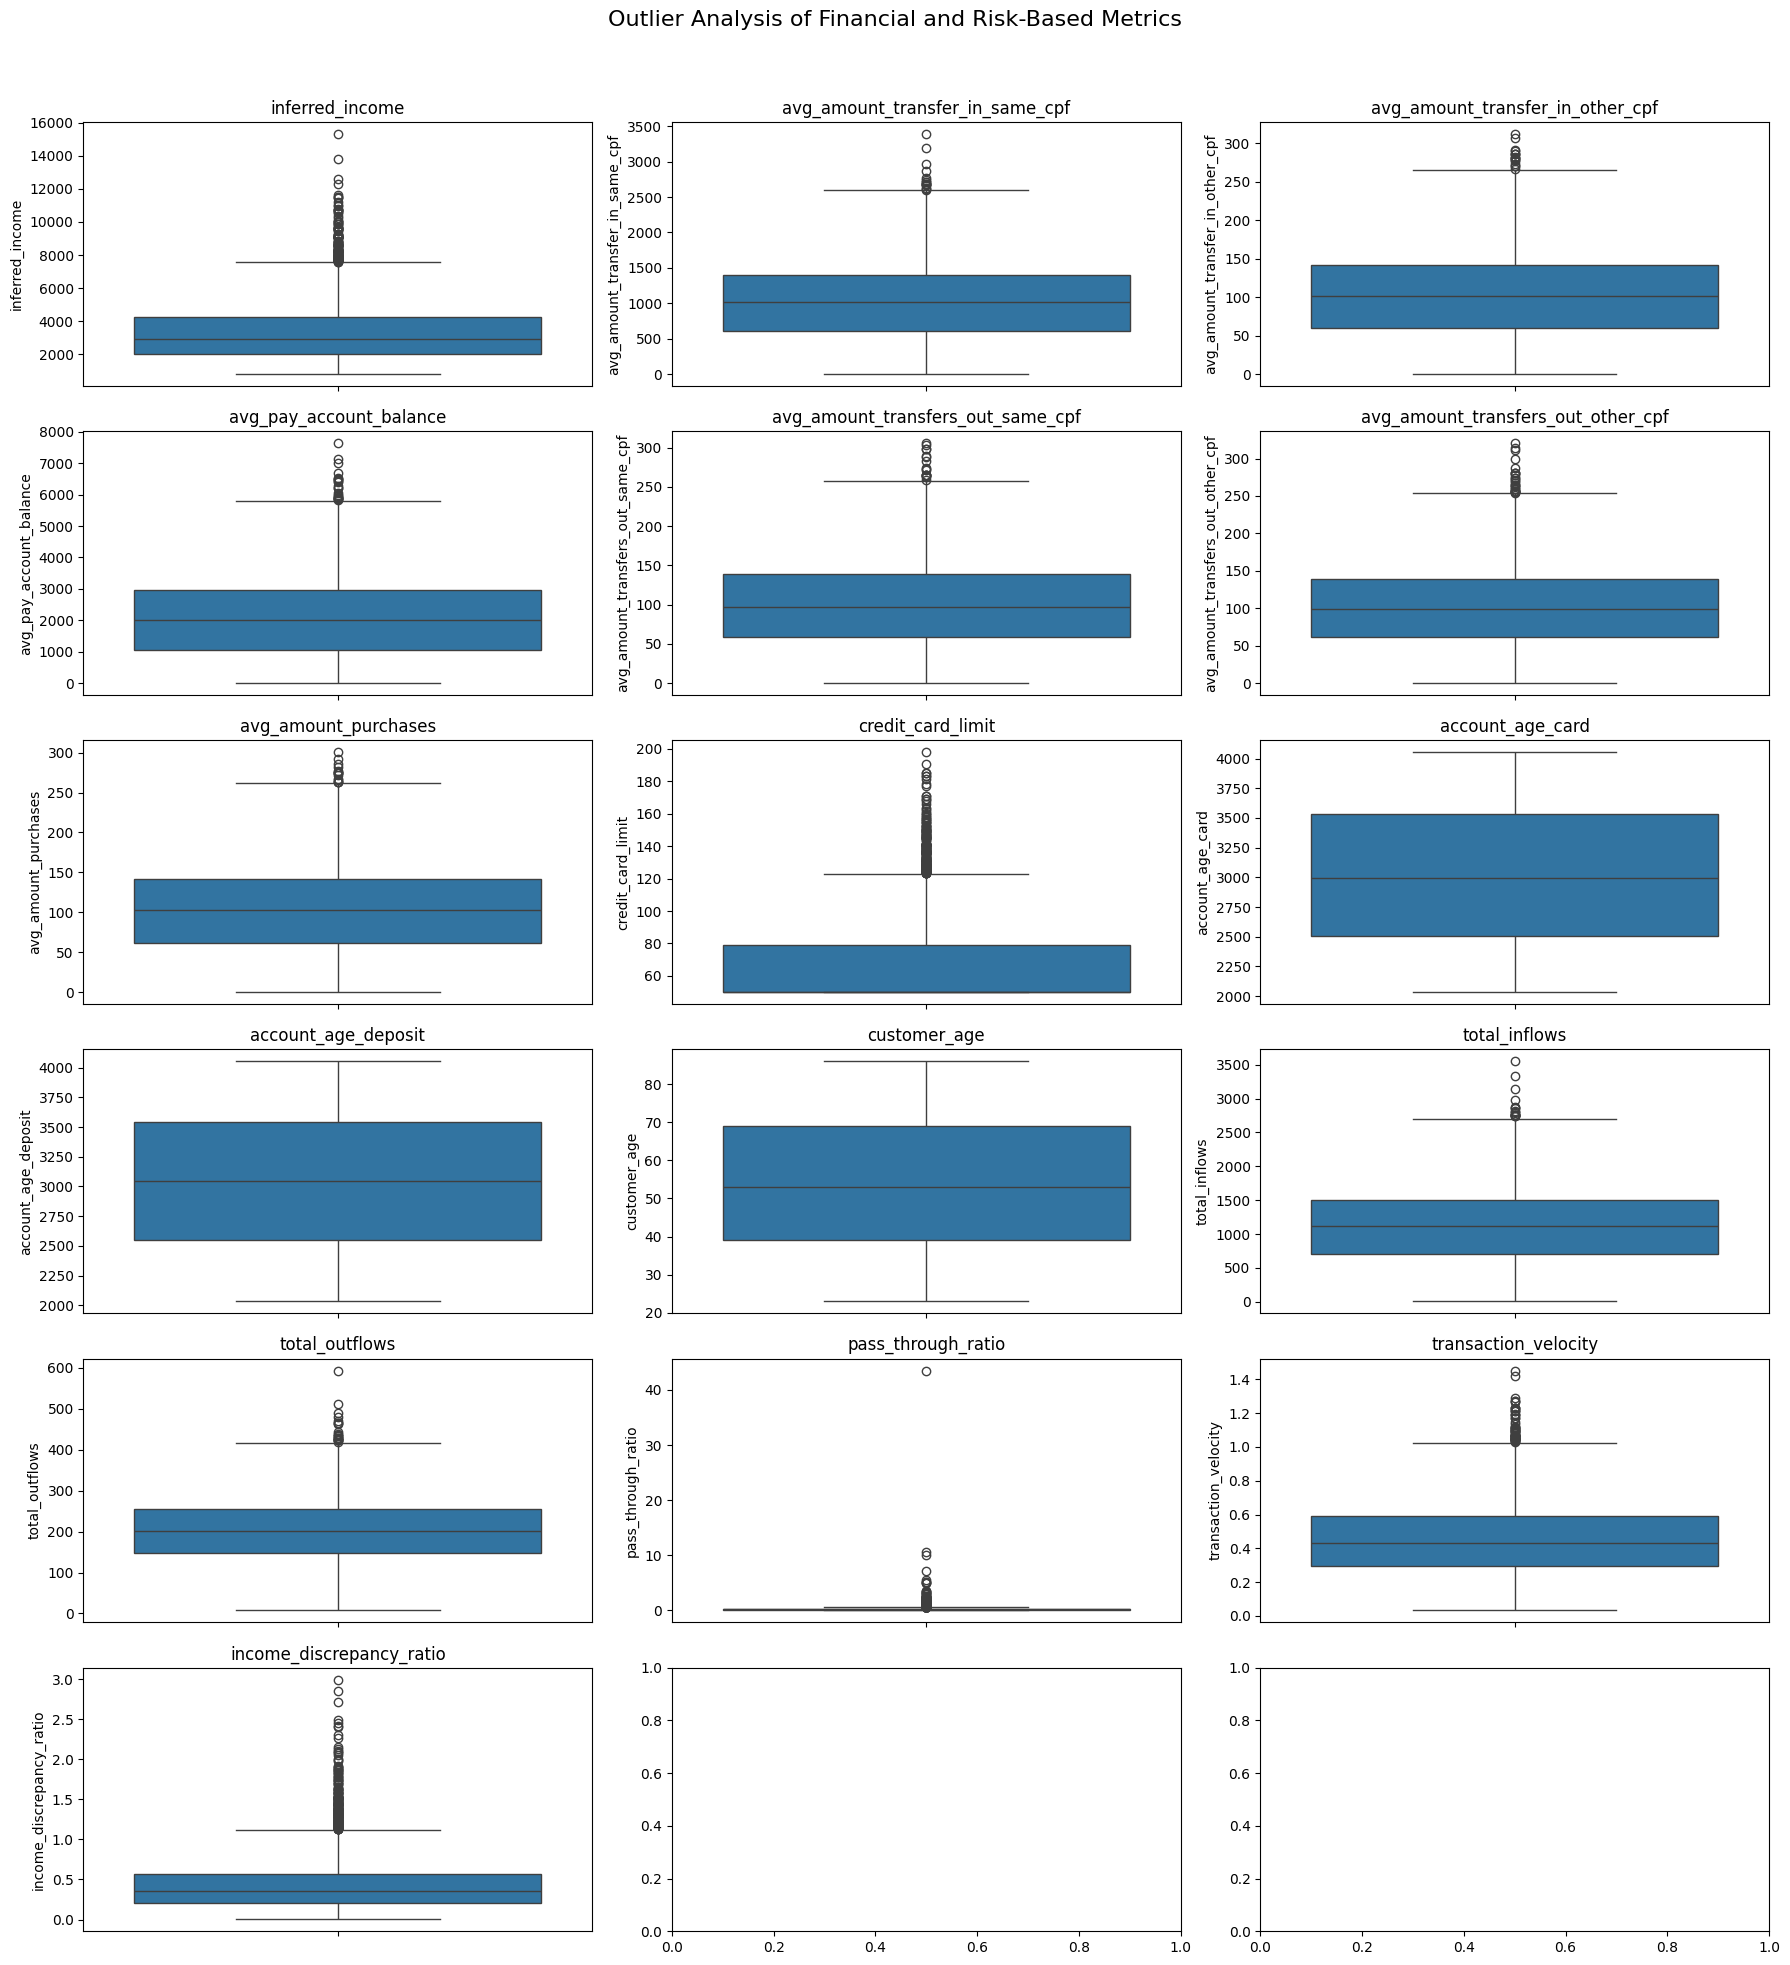

In [ ]:
# Identify potential outliers in all financial metrics using boxplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 20))
fig.suptitle("Outlier Analysis of Financial and Risk-Based Metrics", fontsize=16)

for ax, col in zip(axes.flatten(), all_metrics):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()


#**5. Correlation Analysis**

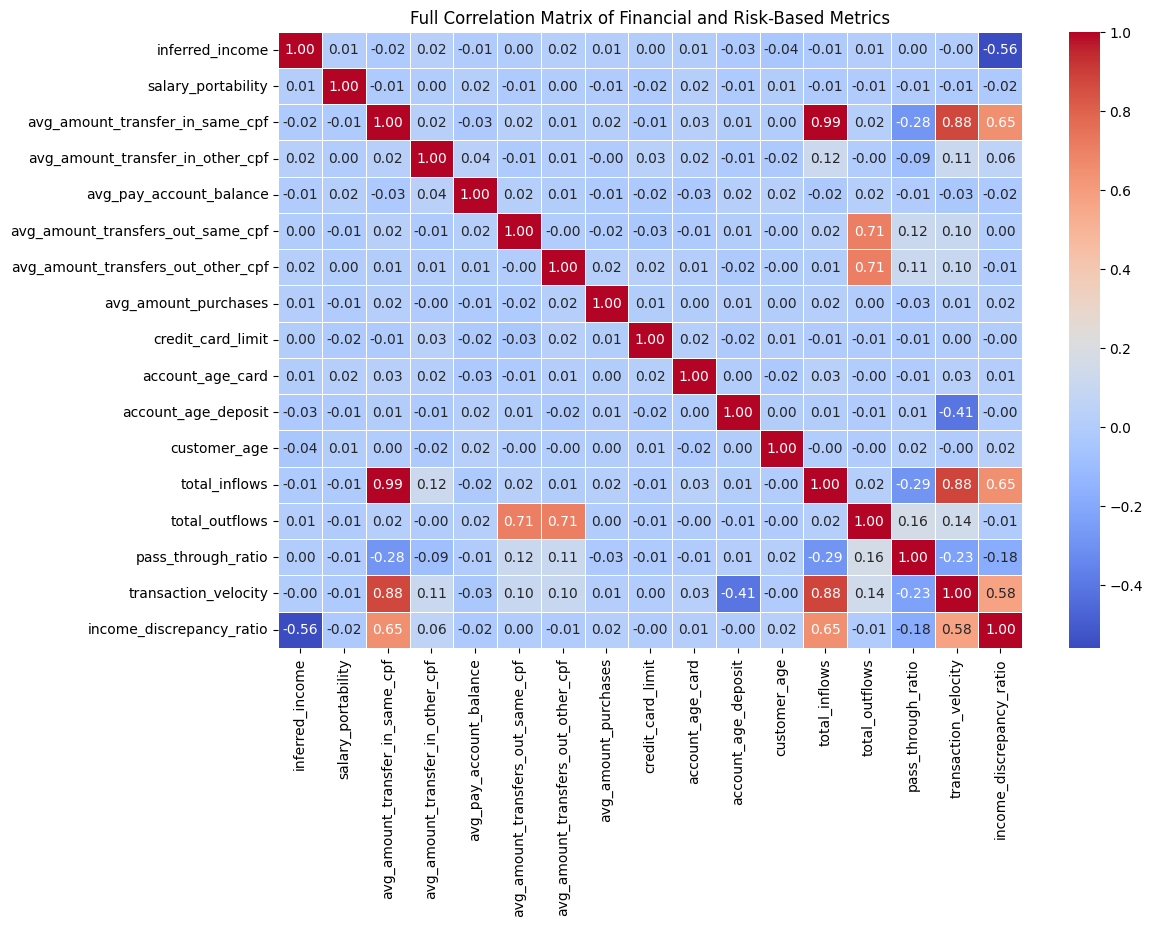

In [ ]:
# Compute correlation matrix for all numerical metrics
full_correlation_matrix = df.corr(numeric_only=True)  # Ensures compatibility with latest pandas versions

# Plot the heatmap for full correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(full_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Full Correlation Matrix of Financial and Risk-Based Metrics")
plt.show()


#**6. Cluster Analysis**

In [ ]:
from sklearn.preprocessing import StandardScaler


features_for_clustering = [
    'total_inflows', 'total_outflows', 'pass_through_ratio', 'transaction_velocity',
    'income_discrepancy_ratio', 'avg_pay_account_balance', 'account_age_deposit',
    'account_age_card', 'salary_portability', 'customer_age'
]

state_counts = df['state_of_address'].value_counts(normalize=True)
df['state_encoded'] = df['state_of_address'].map(state_counts)


features_for_clustering.append('state_encoded')


df['salary_portability'] = df['salary_portability'].astype(int)


scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features_for_clustering])


df_scaled = pd.DataFrame(df_scaled, columns=features_for_clustering)

df_scaled.head()


,total_inflows,total_outflows,pass_through_ratio,transaction_velocity,income_discrepancy_ratio,avg_pay_account_balance,account_age_deposit,account_age_card,salary_portability,customer_age,state_encoded
0,-0.896374,0.317688,0.083322,-0.543480,-0.162025,-0.847860,-0.864412,-1.613633,1.027375,-1.224939,-0.736560
1,1.431004,0.405956,-0.212401,1.913842,1.510644,-0.266938,-0.950868,1.063436,1.027375,0.068615,0.407961
2,-0.583973,-1.014080,-0.173850,-0.457982,-0.187412,-0.306388,-0.755478,-0.084854,1.027375,0.462305,1.035247
3,-0.768907,0.657806,0.085284,0.026802,-0.920710,-0.727329,-1.670180,-1.112002,-0.973355,1.137202,-0.538470
4,-1.372056,-1.308349,-0.025322,-1.149713,-0.859608,0.544747,-1.369314,-0.047317,1.027375,0.181097,-0.296359


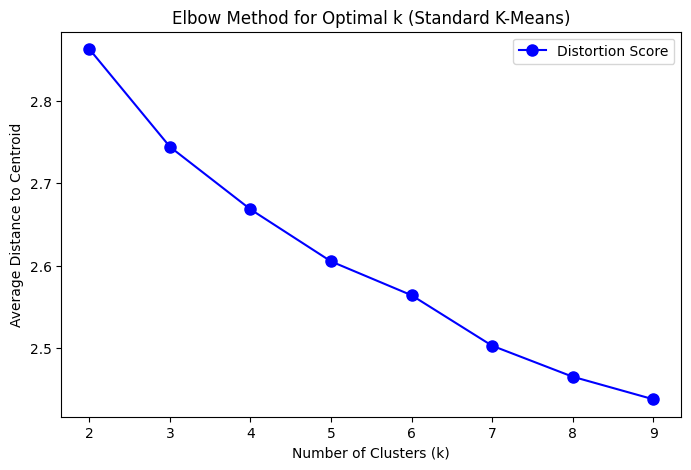

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np


df_sampled = df_scaled.sample(n=min(2000, len(df_scaled)), random_state=42)

# Use standard K-Means for clustering
distortions = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_sampled)
    distortions.append(sum(np.min(cdist(df_sampled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df_sampled.shape[0])

# Plot the Elbow Method graph using standard K-Means
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-', markersize=8, label='Distortion Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Distance to Centroid')
plt.title('Elbow Method for Optimal k (Standard K-Means)')
plt.legend()
plt.show()


In [ ]:
kmeans_test = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_test.fit(df_scaled)


df['cluster'] = kmeans_test.labels_

# Display a sample of the clustered dataset
print(df.groupby('cluster').size())

cluster
0    1371
1    1386
2    1243
dtype: int64


In [ ]:
# Compute summary statistics for each cluster
cluster_summary = df.groupby('cluster')[[
    'total_inflows', 'total_outflows', 'pass_through_ratio',
    'transaction_velocity', 'income_discrepancy_ratio',
    'avg_pay_account_balance', 'account_age_deposit',
    'account_age_card', 'salary_portability', 'customer_age',
    'state_encoded'
]].mean().reset_index()


cluster_summary

,cluster,total_inflows,total_outflows,pass_through_ratio,transaction_velocity,income_discrepancy_ratio,avg_pay_account_balance,account_age_deposit,account_age_card,salary_portability,customer_age,state_encoded
0,0,850.048935,200.434376,0.384960,0.337672,0.295303,2123.629292,3158.952589,2999.379285,0.000000,53.567469,0.047321
1,1,870.188218,198.880974,0.352179,0.351721,0.306356,2165.779870,3106.220058,3024.378788,1.000000,53.958153,0.046631
2,2,1737.144803,211.407667,0.127342,0.702343,0.750627,2022.246533,2844.343524,3059.525342,0.450523,53.815768,0.047806


In [ ]:

features_for_clustering = [
    'total_inflows', 'total_outflows', 'pass_through_ratio', 'transaction_velocity',
    'income_discrepancy_ratio', 'avg_pay_account_balance', 'account_age_deposit',
    'account_age_card', 'salary_portability', 'customer_age', 'state_encoded'
]


today = pd.to_datetime("today")
df['account_age_card'] = (today - pd.to_datetime(df['card_account_since'], errors='coerce')).dt.days
df['account_age_deposit'] = (today - pd.to_datetime(df['deposit_account_since'], errors='coerce')).dt.days

# Ensure customer age is calculated
df['customer_age'] = (today - pd.to_datetime(df['date_of_birth'], errors='coerce')).dt.days // 365

# Drop any rows with NaN values in clustering features
df.dropna(subset=features_for_clustering, inplace=True)

# Define risk score based on key financial behaviors
df['risk_score'] = (
    (df['pass_through_ratio'] > 0.9).astype(int) * 10 +  # High pass-through ratio
    (df['income_discrepancy_ratio'] > 2.0).astype(int) * 8 +  # High income discrepancy
    (df['salary_portability'] == 0).astype(int) * 7  # No salary deposits
)

print(df['risk_score'])


0       0
1       5
2       0
3       7
4       0
       ..
3995    7
3996    7
3997    7
3998    0
3999    7
Name: risk_score, Length: 4000, dtype: int64


In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)
df['dbscan_cluster'] = dbscan.fit_predict(df_scaled)

# Display number of clusters (DBSCAN assigns -1 to outliers)
cluster_counts = df['dbscan_cluster'].value_counts()


print(cluster_counts)

dbscan_cluster
-1    4000
Name: count, dtype: int64
